<a href="https://colab.research.google.com/github/shubham-arote/Agentic-Corrective-Rag-System/blob/main/Auto_agentic_corrective_rag_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building agentic corrective RAG System with LangGraph


In [6]:
!pip install -q langchain langgraph langchain-community langchain-google-genai langchain-chroma langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 6.5 MB/s eta 0:00:00


In [14]:
from google.colab import userdata
import os
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
os.environ['WEATHER_API_KEY'] = userdata.get('WEATHER_API_KEY')
os.environ['GOOGLE_API_KEY']=userdata.get('GOOGLE_API_KEY')
os.environ['TAVILY_API_KEY']=userdata.get('TAVILY_API_KEY')
os.environ['HUGGINGFACE_API_KEY']=userdata.get('HUGGINGFACE_API_KEY')

In [15]:
#Build search Index for wikipedia data
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embedding_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [7]:
from langchain_groq import ChatGroq
chatgpt = ChatGroq(
    model = "llama3-8b-8192",
    temperature = 0
)

Load Documents

In [10]:
import gzip
import json
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
wikipidea_filepath = '/content/drive/MyDrive/simplewiki-2020-11-01.jsonl.gz'
docs = []
with gzip.open(wikipidea_filepath, 'rt', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line.strip())
        #Add all paragraphs
        docs.append(
            {
                'metadata': {
                    'title': data.get('title'),
                    'article_id': data.get('id')

                },
                'data': ' '.join(data.get('paragraphs')[0:3]) # restrict data to first three paragraphs
            }
        )

#we subset ourt data so only use a subset of wikipedia documents
docs = [doc for doc in docs for x in ['india']
        if x in doc['data'].lower().split()]

docs = [Document(page_content=doc['data'], metadata=doc['metadata']) for doc in docs]
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=300)
chunked_docs = splitter.split_documents(docs)
print("chunks:", len(chunked_docs))

chunks: 1322


In [11]:
chunked_docs[0:3]

[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike. The plant tastes somewhat like anise, with a strong, pungent, sweet smell. Basil is very sensitive to cold. It is best grown in hot, dry conditions. While most common varieties are treated as annuals, some are perennial, including African Blue a

In [16]:
from langchain_chroma import Chroma
chroma_db = Chroma.from_documents(documents=chunked_docs,
                                  collection_name= 'rag_wkipedia_db',
                                  embedding=embedding_model,
                                  collection_metadata={"hnsw:space": "cosine"},
                                  persist_directory="./wikipedia_db")

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [17]:
similarity_threshold_retriever = chroma_db.as_retriever(search_type="similarity_score_threshold",
                                                       search_kwargs={"k": 3,
                                                                    "score_threshold": 0.3})

In [18]:
query = "What is the capital of India?"
top3docs = similarity_threshold_retriever.get_relevant_documents(query)
top3docs

/tmp/ipython-input-18-1200600795.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  top3docs = similarity_threshold_retriever.get_relevant_documents(query)
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


[Document(id='c3d46c7a-236f-464f-a25b-50b1745a5612', metadata={'article_id': '22215', 'title': 'States and union territories of India'}, page_content='The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.'),
 Document(id='f26e256d-6a1d-4c8e-9832-66f68c8126ab', metadata={'title': 'Indian Ambassador to the United States', 'article_id': '590927'}, page_content='The Indian Ambassador to the United States is the main representative of India to the United States. They live in the embassy of India in Washington, D.C.'),
 Document(id='723da5aa-f75e-4c91-a469-fa1411b855ba', metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 4

LLM GRADER OF RETRIEVED DOCUMENTS


In [30]:
#Create a Query Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel ,Field
from langchain_google_genai import ChatGoogleGenerativeAI

#Data model for LLM output format
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved document"""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# prompt template for grading
SYS_PROMPT = """You are an expert grader assessing relevance of a retrieved document to a user question
                Follow these instructions for grading:
                -If the document contains keywords(s) or semantic meaning related to question ,grade it as relevant.
                -Your grade should be either 'yes' or 'no' to indicate whether the document is relevant to the question or not
            """
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Retrieved document:
                    {document}
                    User Question:
                    {question}
                    """),
    ]
)
#Build grader chain

doc_grader =(grade_prompt | structured_llm_grader)

In [24]:
query = "What is the capital of pakistan?"
top3docs = similarity_threshold_retriever.get_relevant_documents(query)
for doc in top3docs:
    print(doc.page_content)
    print('GRADE:',doc_grader.invoke({"question": query,"document": doc.page_content,}))
    print()

A capital city (or capital town or just capital) is a city or town, specified by law or constitution, by the government of a country, or part of a country, such as a state, province or county. It usually serves as the location of the government's central meeting place and offices. Most of the country's leaders and officials work in the capital city. Capitals are usually among the largest cities in their regions; often they are the biggest. For example, Montevideo is Uruguay's capital as well as its biggest city. The capital city may also be the most important center of commerce, as in London or Bangkok. However, a capital is not always the largest city in a country. For example, the capital of the India is New Delhi, which is smaller than Mumbai; and the capital of Pakistan is Islamabad, which is smaller than Karachi. Also, in countries with subdivisions like the United States, the capital cities or towns of the federated states are often not the largest or most populated town. For exa

In [25]:
query = "who won the champions league in 2024"
top3docs = similarity_threshold_retriever.invoke(query)
for doc in top3docs:
    print(doc.page_content)
    print(doc_grader.invoke({"document": doc.page_content, "question": query}))
    print()

India Today is a weekly Indian English-language news magazine published by Living Media India Limited.
binary_score='no'

The Supreme Court of India is the highest court of India which gives justice to people if they had made any offence.
binary_score='no'

Srinagar (, ) is a city in Jammu and Kashmir, it is claimed by Pakistan and India. It is situated on the banks of the Jhelum River, in Northern India occupied Kashmir region. It is the largest city and the summer capital of the Indian state of Jammu and Kashmir.
binary_score='no'



QA RAG CHAIN

In [26]:
#Build QA rag chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

prompt = """You are an assistant for question-answering task
            Use the following pieces of retrieved context to answer the question.
            If no context is present or if you don't know the answer, just say that you don't know the answer.
            Do not make up the answer unless it is there in the provided context.
            Give a detaield answer and to the point answer with regard to the question
            Question:
            {question}
            Context:
            {context}
            Answer:
        """
prompt_template = ChatPromptTemplate.from_template(prompt)
chat_gpt = ChatGoogleGenerativeAI(model="gemini-1.5-pro",temperature=0)

def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

qa_rag_chain =(
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter('question')
    }
     |
    prompt_template
     |
    chatgpt
     |
    StrOutputParser()
)

In [27]:
query = "what is capital of pakistan"
top3docs = similarity_threshold_retriever.invoke(query)
result =qa_rag_chain.invoke({"context": top3docs,"question": query})
print(result)
type(result)

According to the provided context, the capital of Pakistan is Islamabad.


str

Query Rephraser

In [31]:
#Create a Query Rephraser
#prompt template

SYS_PROMPT = """Act as a question re-writer and perform the following task:
                -convert the following input question to a better version that is optimized for web search
                -when re-writing the question, look at the input question and try to reason about the underlying semantic meaning
                -generate only one question in string format
            """
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        ("human", """Here is initial question:
                    {question}
                    formulate an improved question
                """)
    ]
)
question_rewriter = (re_write_prompt | llm | StrOutputParser())

In [32]:
query = "who won the champions league in 2024"
question_rewriter.invoke({"question": query})

'What was the result of the 2024 UEFA Champions League final, and which team emerged as the winner?'

In [ ]:
#!pip install --upgrade --quiet  duckduckgo-search

In [33]:
from langchain_community.tools.tavily_search import TavilySearchResults
tv_search = TavilySearchResults(max_results=3, search_depth= 'advanced',
                                    max_tokens =10000)

/tmp/ipython-input-33-459900129.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tv_search = TavilySearchResults(max_results=3, search_depth= 'advanced',


In [34]:
!pip install -q duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.2 MB/s eta 0:00:00


In [35]:
# load web search tool

from langchain_community.tools import DuckDuckGoSearchResults
search = DuckDuckGoSearchResults(max_results=3, search_depth='advanced',
                                max_tokens=1000)

In [36]:
docs =search.invoke("who won the champions league in 2024")
docs

"snippet: Route to glory, key stats; all you need to know about 2024/25 UEFA Champions League winners Paris., title: Paris win Champions League: Meet the 2024/25 victors - UEFA.com, link: https://www.uefa.com/uefachampionsleague/news/0299-1db3ed7babb3-e6227af6104f-1000--paris-win-champions-league-meet-the-2024-25-victors/, snippet: With their 5-0 victory over Inter Milan in the final of the 2024-2025 Champions League on Saturday 31st May, Paris Saint-Germain have made history by winning the trophy for the first time. Supported by 18,000 fans in Munich, and many more in Paris, throughout France and around the world, the Rouge & Bleu added a 55th title to their trophy cabinet with Europe's most prestigious prize., title: Paris Saint-Germain win the Champions League for the first time in ..., link: https://www.psg.fr/en/content/paris-saint-germain-win-the-champions-league-for-the-first-time-in-their-history, snippet: The UEFA Champions League is the most celebrated club tournament in the 

Graph State

In [37]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph

    Attributes:
        qustion: quetions
        generation: LLM response generation
        web_search_needed: whether to add web search
        documents: list of context document
    """
    question: str
    generation: str
    web_search_needed: str
    documents: List[str]


In [38]:
#retreive funtion  for retrival from vector df
def retrieve(state):
    """
    Retrieve documents
    Args:
        state(dict): The current graph state
    Returns:
        state(dict): New key added to state, documents - that contains the retrieved context documents
    """
    print("--RETRIEVAL FROM VECTOR DETABASE --")
    question =state["question"]
    documents = similarity_threshold_retriever.invoke(question)
    return {"documents": documents, "question": question}


In [39]:
#grade documents
def grade_documents(state):
        """
        Determines whether the retrieved documents are relevant to the question
        by using an LLM Grader
        If any document are not relevant to the question or documents are empty - Web search needs to be done
        If all documents are relevant to the question web search is not needed
        Helps filtering out irrelevant documents
        Args:
            state(dict): The current graph state
        Returns:
            state(dict): Updates document key with only filtered documents
        """
        print("--CHECK DOCUMENT RELEVANCE TO QUESTION")
        question = state["question"]
        documents = state["documents"]

        #score each document
        filtered_docs =[]
        web_search_needed = "No"
        if documents:
            for d in documents:
                score = doc_grader.invoke(
                    {"question": question, "document": d.page_content})
                grade = score.binary_score
                if grade == "yes":
                    print("--GRADE: DOCUMENT RELEVANT--")
                    filtered_docs.append(d)
                else:
                    print("--GRADE: DOCUMENT NOT RELEVANT")
                    web_search_needed = "Yes"
                    continue
        else:
            print("--NO DOCUMENTS RETRIEVED--")
            web_search_needed = "Yes"
        return {"documents":filtered_docs, "question":question, "web_search_needed": web_search_needed}

In [40]:
#Rewrite query
def rewrite_query(state):
    """
    Rewrite the query to produce better question.

    Args:
        state(dict): the current graph state
    Returns:
        state(dict): Updates question key with a rephrased or re-written question
    """
    print("--REWRITE QUERY--")
    question = state["question"]
    documents= state["documents"]

    # rewrite question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}
    print(better_question)


In [41]:
#Web Search
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the re-written question.

    Args:
        state(dict): The current graph state
    Returns:
        state(dict): Updates documents key with appended web results
    """
    print("--WEB SEARCH--")
    question = state["question"]
    documents = state["documents"]
    #web search
    docs = tv_search.invoke(question)
    web_result = "\n\n".join([d["content"] for d in docs])
    web_result = Document(page_content= web_result)
    documents.append(web_result)
    return {"documents": documents, "question": question}


In [42]:
#Generate Answer
def generate_answer(state):
    """
    Generate answer from context document using LLM

    Args:
        state(dict): The current graph state
    Returns:
        state(dict): New key added to state, generation , that contains the LLM response
    """
    print("--GENERATE ANSWER--")
    question = state["question"]
    documents = state["documents"]
    generation = qa_rag_chain.invoke({"context": documents, "question": question })
    return {"documents":documents,"question": question,"generation": generation }


Decide to Generate


In [43]:
#decide to  generate

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question

    Arg:
        state(dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS--")
    web_search_needed = state["web_search_needed"]

    if web_search_needed == "Yes":
    #All documents have been filtered check_relevance
    #We will re-generate new query
        print("---DECISION: SOME OR ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY--")
        return "rewrite_query"
    else:
    #we have relevant documents so generate answer
        print("--DECISION: GENERATE RESPONSE--")
        return "generate_answer"


In [44]:
# Build the agent graph
from langgraph.graph import END, StateGraph
agentic_rag = StateGraph(GraphState)

#Define the nodes
agentic_rag.add_node("retrieve", retrieve)
agentic_rag.add_node("grade_documents", grade_documents)
agentic_rag.add_node("rewrite_query",  rewrite_query)
agentic_rag.add_node("web_search", web_search)
agentic_rag.add_node("generate_answer", generate_answer)

#Build graph
agentic_rag.set_entry_point("retrieve")
agentic_rag.add_edge("retrieve", "grade_documents")
agentic_rag.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"rewrite_query": "rewrite_query", "generate_answer":"generate_answer"}
)
agentic_rag.add_edge("rewrite_query", "web_search")
agentic_rag.add_edge("web_search", "generate_answer")
agentic_rag.add_edge("generate_answer", END)

agentic_rag = agentic_rag.compile()


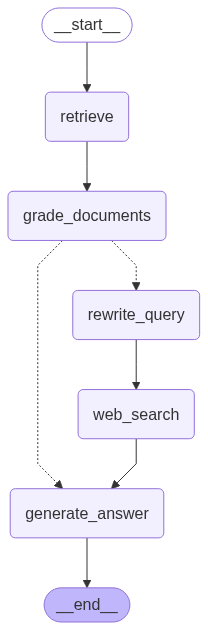

In [45]:
from IPython.display import Image, display, Markdown

display(Image(agentic_rag.get_graph().draw_mermaid_png()))

In [46]:
query = "what is langgraph"
response = agentic_rag.invoke({"question":query})

--RETRIEVAL FROM VECTOR DETABASE --
--CHECK DOCUMENT RELEVANCE TO QUESTION
--GRADE: DOCUMENT NOT RELEVANT
--GRADE: DOCUMENT NOT RELEVANT
--GRADE: DOCUMENT NOT RELEVANT
---ASSESS GRADED DOCUMENTS--
---DECISION: SOME OR ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY--
--REWRITE QUERY--
--WEB SEARCH--
--GENERATE ANSWER--


In [47]:
display(Markdown(response['generation']))

LangGraph is an open-source AI agent framework designed to build, deploy, and manage complex generative AI agent workflows. It uses graph-based architectures to model and manage the relationships between various components of an AI agent workflow, providing transparency into the agent's state. LangGraph is particularly relevant to large language models (LLMs) and graph-based natural language processing (NLP) techniques as it enables the development of complex AI solutions and workflows, including chatbots, state graphs, and other agent-based systems.

In the context of LLMs, LangGraph provides a modular framework for enhancing machine translation using large language models. The framework combines the power of LLMs with the capabilities of LangGraph to analyze complex relationships between nodes, enabling enhanced decision-making and improved performance in machine translation tasks.

LangGraph's graph-based architecture allows it to model intricate relationships between nodes, which represents individual components or agents within an AI workflow. This enables LangGraph to analyze the past actions and feedback of these nodes, leading to more informed decision-making and improved performance in tasks such as machine translation.

In summary, LangGraph is a powerful framework that leverages graph-based architectures and LLMs to build and scale complex AI workloads, including conversational agents, complex task automation, and custom LLM-backed experiences. Its ability to model complex relationships between nodes and analyze past actions and feedback makes it particularly well-suited for applications that require enhanced decision-making and improved performance.

In [ ]:
query = "who won icc the world cup in 2024?"
response = agentic_rag.invoke({"question": query})

--RETRIEVAL FROM VECTOR DETABASE --
--CHECK DOCUMENT RELEVANCE TO QUESTION
--GRADE: DOCUMENT NOT RELEVANT
--GRADE: DOCUMENT NOT RELEVANT
--GRADE: DOCUMENT NOT RELEVANT
---ASSESS GRADED DOCUMENTS--
---DECISION: SOME OR ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY--
--REWRITE QUERY--
--WEB SEARCH--
--GENERATE ANSWER--


In [ ]:
from IPython.display import Image, display, Markdown
display(Markdown(response['generation']))

In [51]:
query = "who won cricket world cup in 2011"
response = agentic_rag.invoke({"question":query})

--RETRIEVAL FROM VECTOR DETABASE --
--CHECK DOCUMENT RELEVANCE TO QUESTION
--GRADE: DOCUMENT RELEVANT--
--GRADE: DOCUMENT NOT RELEVANT
--GRADE: DOCUMENT RELEVANT--
---ASSESS GRADED DOCUMENTS--
---DECISION: SOME OR ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, REWRITE QUERY--
--REWRITE QUERY--
--WEB SEARCH--
--GENERATE ANSWER--


In [52]:
display(Markdown(response['generation']))

According to the provided context, India won the ICC Cricket World Cup in 2011, defeating Sri Lanka by 6 wickets in the final at the Wankhede Stadium in Mumbai.